In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def lin_reg(theta,x):
    w, b = theta
    return w*x+b
def least_square(theta, x, y):
    pred = lin_reg(theta, x)
    return jnp.mean((pred - y)**2)
def update(theta, x, y, lr = 0.2):
    return theta - lr*jax.grad(least_square, argnums=(0))(theta, x, y)

In [36]:
x = jnp.linspace(0,1,101)
theta = jnp.array([1.,1.])
y = 3*jnp.linspace(0,1,101)+0.5
for i in range(200):
    theta = update(theta, x, y)

In [3]:
change = np.linspace(0,10,101)
trace = []
G = np.array([[1,0],[0,2]])
H = np.array([[1,0],[0,2]])
for i in range(len(change)):
    F = np.array([[1,change[i]],[change[i],1]])
    a = np.block([[G, F],[-np.conj(F).T, -H]])
    U = (scipy.linalg.expm(1j*a))[:2,2:]
    trace.append((np.trace(np.conj(U)@U.T))**2/(np.trace((np.conj(U)@U.T)@(np.conj(U)@U.T))))

C:\Users\super\.virtualenvs\pump_optimization-rAbjnRJu\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


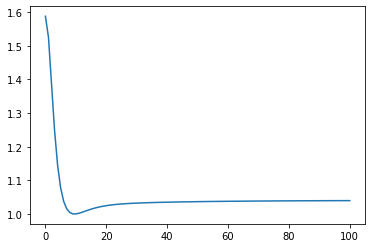

In [4]:
plt.plot(trace)